In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
# import babet as bb
import netCDF4
import dask
import cartopy.crs as ccrs
import tqdm
import cartopy.feature as cfeature

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)

In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [3]:
def accum2rate(ds):
    """
    Function to convert accumulated variables to conventional ones.
    Definition to convert accumulated variables to instantaneous.
    Written by Nick Leach.

    Input:
    ------

    Output:
    -------
    """

    dnew = ds.copy(deep=True)
    oindex = dnew.time
    dnew = dnew.diff('time') / (dnew.time.diff('time').astype(float) / 1e9 )
    dnew = dnew.reindex(time=oindex)
    return dnew[1:]

In [4]:
def preproc_ds(ds):
    """
    Main pre-processing function
    Writtten by Nick Leach and Shirin Ermis.

    Input:
    ------
    ds: xarray dataset

    Output:
    -------
    """

    # accumulated variables & scaling factors
    accumulated_vars = {'tp': 60 * 60 * 24 * 1e3,
                        'ttr': 1,
                        'tsr': 1,
                        'str': 1,
                        'ssr': 1,
                        'e': 1}
    accumulated_var_newunits = {'tp': 'mm day$^{-1}$',
                                'ttr': 'W m$^{-2}$',
                                'tsr': 'W m$^{-2}$',
                                'str': 'W m$^{-2}$',
                                'ssr': 'W m$^{-2}$',
                                'e': 'm s$^{-1}$'}
    ds1 = ds.copy().squeeze()
    # set up aux data
    inidate = pd.to_datetime(ds1.time[0].values)
    # expand dimensions to include extra info
    if not 'hDate' in ds1:
        ds1 = ds1.expand_dims({'inidate': [inidate]}).copy()

    if not 'number' in ds1:
        ds1 = ds1.expand_dims({'number': [0]}).copy()

    # put time dimension at front
    ds1 = ds1.transpose('time', ...)
    ds2 = ds1.copy(deep=True)

    # convert accumulated variables into instantaneous
    for var, sf in accumulated_vars.items():
        if var in ds2.keys():
            var_name = var+"_rate" 
            ds2 = ds2.assign(new=lambda x: accum2rate(x[var]) * sf)
            ds2 = ds2.rename_vars({'new':str(var_name)})
            ds2[var_name].loc[dict(time=ds2.time[1:])] = accum2rate(ds2[var]) * sf
            # set first value to equal zero,
            # should be zero but isn't always
            ds2[var_name].loc[dict(time=ds2.time[0])] = 0
            ds2[var_name].attrs['units'] = accumulated_var_newunits[var]
    return ds2

In [5]:
def hourly2accum(ds, start_day='2023-10-18 09', end_day='2023-10-22 00', m2mm=True):
    """
    Function to convert hourly precipitation to accumulated precipitation in mm.
    Also truncates the data to the desired time period.

    Input:
    ------
    ds: xarray dataset

    Output:
    -------
    ds_out: xarray dataset with precipitation accumulated in mm.
    """
    if m2mm:
        factor = 1000
    else:
        factor = 1
    ds_out = ds.copy(deep=True).sel(time=slice(start_day, end_day))
    ds_out['tp'] = ds_out.tp.cumsum(dim='time')*factor  # sum and convert to mm

    return ds_out

# Import data

In [7]:
base_dir = '/home/e/ermis/Storm_Babet/data/'

In [30]:
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/sfc/pf'
file_dir = {'curr': base_dir.format('curr'),
            'pi': base_dir.format('pi'),
            'incr': base_dir.format('incr')}
inidate = '2023-10-17'
babet_curr = xr.open_mfdataset(os.path.join(file_dir['curr'], '*.nc'), preprocess=preproc_ds, engine='netcdf4').sel(inidate=inidate)
babet_pi = xr.open_mfdataset(os.path.join(file_dir['pi'], 'b2rr*.nc'), preprocess=preproc_ds, engine='netcdf4').sel(inidate=inidate)
babet_incr = xr.open_mfdataset(os.path.join(file_dir['incr'], '*.nc'), preprocess=preproc_ds, engine='netcdf4').sel(inidate=inidate)

In [10]:
# Import ERA5 data
era5_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5/EU025/sfc/'
era5 = xr.open_mfdataset(os.path.join(era5_dir, '*.nc'), engine='netcdf4')
era5 = era5.sel(time=slice('2023-10-17 00', '2023-10-22 00'))

# Calculate cumulative total precipitation

ERA5: sum up 

IFS: Already cumulative from initialisation but we calculated a rate of precip when importing data

In [32]:
starttime = '2023-10-18 09' # Same as Met Office, https://www.metoffice.gov.uk/binaries/content/assets/metofficegovuk/pdf/weather/learn-about/uk-past-events/interesting/2023/2023_08_storm_babet.pdf
endtime = '2023-10-22 00' # Met Office uses 9 hours more

In [33]:
tp_era = hourly2accum(era5, start_day=starttime, end_day=endtime).tp.sel(time=endtime) # m2mm conversion in function
tp_babet_curr =  hourly2accum(babet_curr, start_day=starttime, end_day=endtime).tp.sel(time=endtime)

# Cumulative total precipitation

In [44]:
# Plot settings

# UK
lat_max = 65
lat_min = 45
lon_min = -15
lon_max = 5

# #Europe
# lat_max = 70
# lat_min = 33
# lon_min = -27
# lon_max = 25

tp_min = 0 # Precipitation in mm
tp_max = 200

p_min = 970 # Pressure in hPa
p_max= 1030

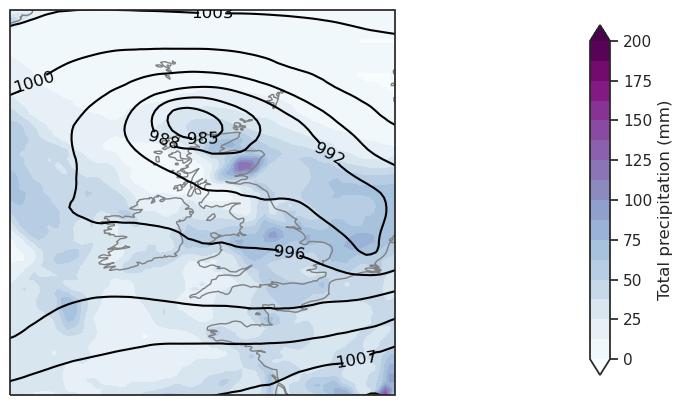

In [45]:
projection = ccrs.PlateCarree()

longitude =tp_era.longitude.values
latitude = tp_era.latitude.values

# figure and map setup
fig = plt.figure(1, figsize=(10, 5))
ax = plt.subplot(1,1,1, projection = projection)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

# data for plotting
tp_vals = tp_era.values
p_vals = era5.msl.sel(time=endtime).values/100

# tp as shading
clevs_tp = np.linspace(tp_min, tp_max, 17)
cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=plt.cm.BuPu,
                transform=projection, 
                extend='both')

# isobars as contours
clevs_p = np.linspace(p_min, p_max, 17)
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                transform=projection)
plt.clabel(cs, fmt='%d')

# colourbar, title etc
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cf, cax=cbar_ax, label='Total precipitation (mm)')
# plt.suptitle('Op. forecast at {} and initialisatio at{}'.format(timestep_plot, inidate))

<a list of 19 text.Text objects>

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


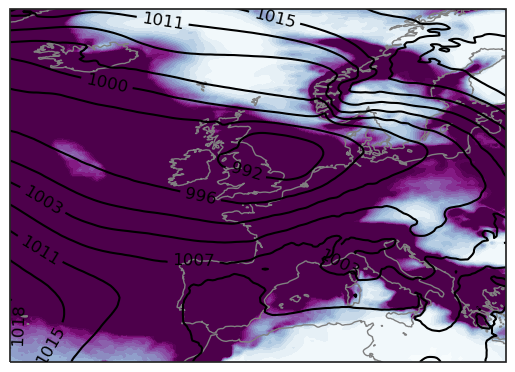

In [42]:
projection = ccrs.PlateCarree()

longitude =tp_era.longitude.values
latitude = tp_era.latitude.values

# figure and map setup
ax = plt.subplot(1,1,1, projection = projection)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

# data for plotting
tp_vals = tp_babet_curr.mean(dim='number').values
p_vals = babet_curr.msl.sel(time=endtime).mean(dim='number').values/100

# tp as shading
clevs_tp = np.linspace(tp_min, tp_max, 17)
cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=plt.cm.BuPu,
                transform=projection, 
                extend='both')

# isobars as contours
clevs_p = np.linspace(p_min, p_max, 17)
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                transform=projection)
plt.clabel(cs, fmt='%d')